In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'1FUZJECbq2GSXnzoBXpptz0-3IapCXUKx'}) # replace the id with id of file you want to access
downloaded.GetContentFile('emotion.zip')

In [0]:
%%capture
!unzip emotion.zip

In [4]:
!ls

adc.json  emotion.zip  meld  sample_data


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "0"

In [0]:
import librosa
import librosa.display
import os, glob, pickle
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest, GenericUnivariateSelect, SelectFromModel, VarianceThreshold
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support

In [0]:
from fastai.vision import *
import torch
import random
from scipy.io import wavfile
from sklearn.model_selection import train_test_split

torch.backends.cudnn.benchmark = False

In [10]:
! ls meld/train/

disgust  fear  happy  neutral  sad


In [0]:
d = {'disgust':2, 'fear':4, 'happy':1, 'neutral':0, 'sad':3}

In [0]:
soundpath1 = "meld/train/disgust/MEL_dia220_utt0_negative_DIS.wav"
soundpath2 = "meld/train/fear/MEL_dia512_utt13_negative_FEA.wav"
soundpath3 = "meld/train/happy/MEL_dia548_utt2_positive_HAP.wav"
soundpath4 = "meld/train/neutral/MEL_dia504_utt5_neutral_NEU.wav"
soundpath5 = "meld/train/sad/MEL_dia449_utt3_negative_SAD.wav"

In [0]:
def sound2features(filename):
    sr, y = wavfile.read(filename)
    y = y.astype('float32')
    y = np.mean(y,axis=1)/32767
    #y, sr = librosa.load(filename, sr = None)
    #S = np.abs(librosa.stft(y))
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    sdb = librosa.feature.melspectrogram(y=y, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    #rms = librosa.feature.rms(y=y)
    #contrast = librosa.feature.spectral_contrast(S=S, sr=sr)
    #flatness = librosa.feature.spectral_flatness(y=y)
    #print(chroma.shape, sdb.shape, mfcc.shape, rms.shape, flatness.shape)
    res = np.concatenate([chroma,sdb,mfcc], axis = 0)
    res = np.mean(res, axis=1)
    return res
    #return np.hstack((np.mean(chroma, axis=1), np.mean(sdb, axis=1), np.mean(mfcc, axis=1)))
    #return np.hstack((np.mean(chroma, axis=1), np.mean(sdb, axis=1), np.mean(mfcc, axis=1), np.mean(rms, axis=1), np.mean(flatness, axis=1)))
    #plt.figure(figsize=(10, 4))
    #librosa.display.specshow(flatness, y_axis='chroma', x_axis='time')
    #plt.colorbar()
    #plt.title('Chromagram')
    #plt.tight_layout()
    #plt.show()

In [0]:
sound2features(soundpath1)

array([ 0.411493,  0.371639,  0.356632,  0.360351, ..., -7.213199, -3.142629, -1.197446, -2.106169])

In [0]:
sound2features(soundpath2)

array([ 0.303381,  0.307455,  0.320904,  0.380943, ..., -0.18579 , -2.148121,  2.717266,  8.083936])

In [0]:
sound2features(soundpath3)

array([ 0.401699,  0.433836,  0.467144,  0.339173, ...,  2.101832,  3.169545, -7.477316, -0.215814])

In [0]:
sound2features(soundpath4)

array([ 0.224056,  0.257642,  0.409112,  0.459822, ..., -1.845401, -4.831304, -5.409285,  1.255991])

In [0]:
sound2features(soundpath5)

array([ 0.278147,  0.399796,  0.353631,  0.262825, ..., -2.879166, -2.626762, -8.842058, -1.172978])

In [0]:
#from pathlib import Path
path = Path('meld/train/')
lengths = []
print(path)
for p in path.ls():
    tag = str(p).split("/")[-1]
    print(tag, end =" ")
    for item in p.ls():
        fname = str(item).split("/")[-1]
        sr, y = wavfile.read(str(item))
        y = y.astype('float32')
        y = np.mean(y,axis=1)/32767
        s = librosa.feature.spectral_centroid(
                y=y, sr=sr, hop_length=512
            )
        lengths.append(len(s[0]))

meld/train
neutral happy disgust sad fear 

In [0]:
#from pathlib import Path
path = Path('meld/val/')
print(path)
for p in path.ls():
    tag = str(p).split("/")[-1]
    print(tag, end =" ")
    for item in p.ls():
        fname = str(item).split("/")[-1]
        sr, y = wavfile.read(str(item))
        y = y.astype('float32')
        y = np.mean(y,axis=1)/32767
        s = librosa.feature.spectral_centroid(
                y=y, sr=sr, hop_length=512
            )
        lengths.append(len(s[0]))

meld/val
neutral happy disgust sad fear 

In [0]:
min(lengths), max(lengths), sum(lengths)/len(lengths)

(3, 9531, 101.88013196480938)

In [0]:
def folder2features(folder):
    x = []
    y = []
    for p in folder.ls():
        tag = str(p).split("/")[-1]
        print(tag, end = " ")
        for soundfile in p.ls():
            x.append(sound2features(str(soundfile)))
            y.append(d[tag])
    x = np.array(x)
    y = np.array(y)
    return x, y

In [0]:
x_train, y_train = folder2features(Path('meld/train/'))

neutral happy disgust sad fear 

In [0]:
x_val, y_val = folder2features(Path('meld/val/'))

neutral happy disgust sad fear 

In [0]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

In [0]:
#with open('xtrain.pkl','wb') as f: pickle.dump(x_train, f)
#with open('ytrain.pkl','wb') as f: pickle.dump(y_train, f)
#with open('xval.pkl','wb') as f: pickle.dump(x_val, f)
#with open('yval.pkl','wb') as f: pickle.dump(y_val, f)

In [0]:
with open('xtrain.pkl','rb') as f: x_train = pickle.load(f)
with open('ytrain.pkl','rb') as f: y_train = pickle.load(f)
with open('xval.pkl','rb') as f: x_val = pickle.load(f)
with open('yval.pkl','rb') as f: y_val = pickle.load(f)

In [0]:
ct = {0:0, 1:0, 2:0, 3:0, 4:0}

In [0]:
for i in y_train:
    ct[i]+=1

In [0]:
ct

{0: 4592, 1: 1609, 2: 232, 3: 705, 4: 216}

In [0]:
print(4592, 4592+1609, 4592+1609+232, 4592+1609+232+705, 4592+1609+232+705+216)

4592 6201 6433 7138 7354


In [0]:
oversample = [3, 18, 6, 18] 

In [0]:
x_trainnew = []
x_trainnew.extend(x_train[:4592])
for i in range(oversample[0]):
    x_trainnew.extend(x_train[4592:6201])
for i in range(oversample[1]):
    x_trainnew.extend(x_train[6201:6433])
for i in range(oversample[2]):
    x_trainnew.extend(x_train[6433:7138])
for i in range(oversample[3]):
    x_trainnew.extend(x_train[7138:])
x_trainnew = np.array(x_trainnew)

In [0]:
y_trainnew = []
y_trainnew.extend(y_train[:4592])
for i in range(oversample[0]):
    y_trainnew.extend(y_train[4592:6201])
for i in range(oversample[1]):
    y_trainnew.extend(y_train[6201:6433])
for i in range(oversample[2]):
    y_trainnew.extend(y_train[6433:7138])
for i in range(oversample[3]):
    y_trainnew.extend(y_train[7138:])
y_trainnew = np.array(y_trainnew)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.001, random_state=42)
x_trainnew, x_testnew, y_trainnew, y_testnew = train_test_split(x_trainnew, y_trainnew, test_size=0.001, random_state=42)

In [0]:
def func(x):
    return np.mean(x, 2)

In [0]:
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

In [524]:
clf = MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-06,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.01, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.00001,
              validation_fraction=0.1, verbose=False, warm_start=True)
clf = OneVsOneClassifier(SVC())
clf.fit(func(x_trainnew), y_trainnew)
y_pred=clf.predict(func(x_train))
print("Train accuracy    :",accuracy_score(y_true=y_train, y_pred=y_pred))
y_pred=clf.predict(func(x_trainnew))
print("Trainnew accuracy :",accuracy_score(y_true=y_trainnew, y_pred=y_pred))
y_pred=clf.predict(func(x_val))
print("Val accuracy      :",accuracy_score(y_true=y_val, y_pred=y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default 

Train accuracy    : 0.9978219439150559
Trainnew accuracy : 0.998415583205182
Val accuracy      : 0.6228915662650603


In [525]:
confusion_matrix(y_val, y_pred)

array([[517,   0,   0,   0,   0],
       [181,   0,   0,   0,   0],
       [ 28,   0,   0,   0,   0],
       [ 79,   0,   0,   0,   0],
       [ 25,   0,   0,   0,   0]])

In [0]:
from sklearn.decomposition import PCA

In [0]:
pca = PCA(n_components=10)
xtpca = pca.fit_transform(func(x_train))
xtnewpca = pca.transform(func(x_trainnew))
xvpca = pca.transform(func(x_val))

In [673]:
clf = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=3))
clf.fit(xtnewpca, y_trainnew)
y_pred=clf.predict(xtpca)
print("Train accuracy    :",accuracy_score(y_true=y_train, y_pred=y_pred))
y_pred=clf.predict(xtnewpca)
print("Trainnew accuracy :",accuracy_score(y_true=y_trainnew, y_pred=y_pred))
y_pred=clf.predict(xvpca)
print("Val accuracy      :",accuracy_score(y_true=y_val, y_pred=y_pred))

Train accuracy    : 0.7723931391233324
Trainnew accuracy : 0.921431567174612
Val accuracy      : 0.3385542168674699


In [674]:
confusion_matrix(y_val, y_pred)

array([[198, 178,  23,  85,  33],
       [ 67,  66,  11,  28,   9],
       [ 12,   9,   1,   6,   0],
       [ 35,  26,   2,  13,   3],
       [ 12,   7,   1,   2,   3]])

In [0]:
from sklearn.feature_selection import SelectKBest, chi2

In [0]:
pca = SelectKBest(chi2, k=3)
xtnewpca = pca.fit_transform(func(x_trainnew), y_trainnew)
xtpca = pca.transform(func(x_train))
xvpca = pca.transform(func(x_val))

In [684]:
clf = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=3))
clf.fit(xtnewpca, y_trainnew)
y_pred=clf.predict(xtpca)
print("Train accuracy    :",accuracy_score(y_true=y_train, y_pred=y_pred))
#y_pred=clf.predict(xtnewpca)
#print("Trainnew accuracy :",accuracy_score(y_true=y_trainnew, y_pred=y_pred))
y_pred=clf.predict(xvpca)
print("Val accuracy      :",accuracy_score(y_true=y_val, y_pred=y_pred))

Train accuracy    : 0.7736182956711135
Val accuracy      : 0.336144578313253


In [685]:
confusion_matrix(y_val, y_pred)

array([[192, 186,  20,  95,  24],
       [ 56,  78,   5,  29,  13],
       [  7,  17,   1,   3,   0],
       [ 34,  28,   7,   7,   3],
       [ 10,   8,   1,   5,   1]])

In [0]:
x_traint = torch.from_numpy(x_train).float().cuda()
y_traint = torch.from_numpy(y_train).long().cuda()
x_trainnewt = torch.from_numpy(x_trainnew).float().cuda()
y_trainnewt = torch.from_numpy(y_trainnew).long().cuda()
x_valt = torch.from_numpy(x_val).float().cuda()
y_valt = torch.from_numpy(y_val).long().cuda()

In [566]:
print(x_traint.shape, y_traint.shape, x_trainnewt.shape, y_trainnewt.shape, x_valt.shape, y_valt.shape)

torch.Size([7346, 43, 94]) torch.Size([7346]) torch.Size([21459, 43, 94]) torch.Size([21459]) torch.Size([830, 43, 94]) torch.Size([830])


In [0]:
class mymodel(nn.Module):
    def __init__(self, in_features, n_classes = 5):
        super().__init__()
        self.linear1 = nn.Linear(in_features,150)
        self.linear2 = nn.Linear(150,100)
        self.linear3 = nn.Linear(100,100)
        self.linear4 = nn.Linear(100,100)
        self.linear5 = nn.Linear(100, n_classes)
        self.act = nn.LeakyReLU(0.1)
        self.softmax = nn.Softmax(-1)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.act(x)
        x = self.linear2(x)
        x = self.act(x)
        x = self.linear3(x)
        x = self.act(x)
        x = self.linear4(x)
        x = self.act(x)
        x = self.linear5(x)
        #x = self.softmax(x)
        #print(x.shape)
        return x

In [0]:
model = mymodel(x_traint.shape[1]).cuda()

In [0]:
loss_function = nn.CrossEntropyLoss()
#loss_function = LabelSmoothingCrossEntropy()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9,0.99), eps=1e-6)
#optimizer = optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-6)
#optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [0]:
def get_batch(X,Y,start,end):
    return X[start:end], Y[start:end]

In [0]:
def train(epochs = 100, bs = 128, X = x_traint, Y = y_traint):
    for epoch in range(epochs):
        i=0
        total_loss = 0.0
        ct = 0
        while i < len(X):
            x,y = get_batch(X,Y,i,i+bs)
            noise = torch.normal(0, 0.005, size=x.shape).cuda()
            #print(noise)
            i+=bs
            ct+=1
            #print(x.shape)
            model.zero_grad()
            preds = model(x+noise)
            loss = loss_function(preds, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        total_loss /= ct
        
        print('epoch',epoch+1,'  ','train loss', "%.3f" % total_loss)

In [0]:
train(200, X = x_trainnewt, Y = y_trainnewt)

In [0]:
preds = model.eval()(x_traint)
accuracy(preds, y_traint)

tensor(0.9293, device='cuda:0')

In [0]:
preds = model.eval()(x_trainnewt)
accuracy(preds, y_trainnewt)

tensor(0.9742, device='cuda:0')

In [0]:
preds = model.eval()(x_valt)
accuracy(preds, y_valt)

tensor(0.4133, device='cuda:0')

In [0]:
pred = np.argmax(preds.cpu().detach().numpy(), 1)
y = y_valt.cpu().numpy()

In [0]:
confusion_matrix(y, pred)

array([[270, 182,  11,  35,  19],
       [ 86,  65,   5,  13,  12],
       [ 10,  14,   2,   2,   0],
       [ 36,  34,   1,   4,   4],
       [ 12,   9,   0,   2,   2]])

In [0]:
precision_recall_fscore_support(y, pred, labels = [0,1,2,3,4])

(array([0.652174, 0.213816, 0.105263, 0.071429, 0.054054]),
 array([0.522244, 0.359116, 0.071429, 0.050633, 0.08    ]),
 array([0.580021, 0.268041, 0.085106, 0.059259, 0.064516]),
 array([517, 181,  28,  79,  25]))

In [0]:
precision_recall_fscore_support(y, pred, average = 'weighted', labels = [0,1,2,3,4])

(0.46483873235358586, 0.41325301204819276, 0.43019751046444543, None)

In [0]:
############################################################################
############################################################################
############################################################################

In [0]:
def sound2features(filename):
    sr, y = wavfile.read(filename)
    y = y.astype('float32')
    y = np.mean(y,axis=1)/32767
    #y, sr = librosa.load(filename, sr = None)
    #S = np.abs(librosa.stft(y))
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    sdb = librosa.feature.melspectrogram(y=y, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    res = np.concatenate([chroma,sdb,mfcc], axis = 0)
    res = torch.from_numpy(res).cuda().reshape(1,1,160,-1)
    return res
    #rms = librosa.feature.rms(y=y)
    #contrast = librosa.feature.spectral_contrast(S=S, sr=sr)
    #flatness = librosa.feature.spectral_flatness(y=y)
    #print(chroma.shape, sdb.shape, mfcc.shape)#, rms.shape, flatness.shape)
    #return np.hstack((np.mean(chroma, axis=1), np.mean(sdb, axis=1), np.mean(mfcc, axis=1)))
    #return np.hstack((np.mean(chroma, axis=1), np.mean(sdb, axis=1), np.mean(mfcc, axis=1), np.mean(rms, axis=1), np.mean(flatness, axis=1)))
    #plt.figure(figsize=(10, 4))
    #librosa.display.specshow(flatness, y_axis='chroma', x_axis='time')
    #plt.colorbar()
    #plt.title('Chromagram')
    #plt.tight_layout()
    #plt.show()

In [0]:
def folder2features(folder):
    x = []
    y = []
    for p in folder.ls():
        tag = str(p).split("/")[-1]
        for soundfile in p.ls():
            x.append(sound2features(str(soundfile)))
            y.append(d[tag])
    y = np.array(y)
    return x, y

In [0]:
xtrain, ytrain = folder2features(Path('meld/train'))

In [0]:
xval, yval = folder2features(Path('meld/val'))

In [0]:
for i in range(len(xtrain)):
    xtrain[i] = xtrain[i].reshape(1,1,160,-1).float().cuda()
for i in range(len(xval)):
    xval[i] = xval[i].reshape(1,1,160,-1).float().cuda()

In [0]:
xtrainnew = []
xtrainnew.extend(xtrain[:4592])
for i in range(2):
    xtrainnew.extend(xtrain[4592:6201])
for i in range(7):
    xtrainnew.extend(xtrain[6201:6433])
for i in range(2):
    xtrainnew.extend(xtrain[6433:7138])
for i in range(7):
    xtrainnew.extend(xtrain[7138:])

In [0]:
ytrainnew = []
ytrainnew.extend(ytrain[:4592])
for i in range(2):
    ytrainnew.extend(ytrain[4592:6201])
for i in range(7):
    ytrainnew.extend(ytrain[6201:6433])
for i in range(2):
    ytrainnew.extend(ytrain[6433:7138])
for i in range(7):
    ytrainnew.extend(ytrain[7138:])

In [0]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [0]:
model = nn.Sequential(
    conv2(1, 32),
    conv2(32, 64),
    conv2(64, 128),
    conv2(128, 256),
    nn.AdaptiveMaxPool2d((1,5)),
    Flatten(),
    nn.Linear(1280,100),
    nn.ReLU(inplace=True),
    nn.Linear(100,5)
).cuda()

In [0]:
loss_function = nn.CrossEntropyLoss()
#loss_function = LabelSmoothingCrossEntropy()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9,0.99), eps=1e-6)
#optimizer = optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-6)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [0]:
def run_batch(X,Y,indexes,start,end):
    model.zero_grad()
    preds = None
    loss = None
    preds = torch.zeros((1,5)).cuda()
    y = []
    for i in indexes[start:end]:
        pred = model(X[i])
        preds = torch.cat((preds,pred), 0)
        del pred
        y.append(Y[i])

    Y = torch.from_numpy(np.array(y)).cuda()
    loss = loss_function(preds[1:], Y)
    loss.backward()
    optimizer.step()
    return loss.item()

In [0]:
def train(epochs = 2, bs = 128):
    for epoch in range(epochs):
        indexes = random.sample(range(len(xtrain)), len(xtrain))
        i=0
        total_loss = 0.0
        ct = 0
        while i < len(xtrain):
            total_loss = run_batch(xtrainnew,ytrainnew,indexes,i,i+bs)
            i+=bs
            ct+=1
            #print(total_loss/bs)
        total_loss /= ct
        
        print('epoch',epoch+1,'  ','train loss', "%.3f" % total_loss)

In [0]:
train(10)  

epoch 1    train loss 0.011
epoch 2    train loss 0.007
epoch 3    train loss 0.007
epoch 4    train loss 0.003
epoch 5    train loss 0.001
epoch 6    train loss 0.001
epoch 7    train loss 0.001
epoch 8    train loss 0.003
epoch 9    train loss 0.001
epoch 10    train loss 0.002


In [0]:
gc.collect()

0

In [0]:
preds = []
for x in xtrain:
    pred = np.argmax(model.eval()(x).cpu().detach().numpy(), 1)
    preds.extend(pred)
preds = np.array(preds)

In [0]:
Y = torch.from_numpy(ytrain)

In [0]:
accuracy_score(Y, preds)

0.7768561327168888

In [0]:
confusion_matrix(Y, preds)

array([[4486,  106,    0,    0,    0],
       [ 382, 1227,    0,    0,    0],
       [ 196,   36,    0,    0,    0],
       [ 615,   90,    0,    0,    0],
       [ 176,   40,    0,    0,    0]])

In [0]:
gc.collect()

164

In [0]:
preds = []
for x in xtrainnew:
    pred = np.argmax(model.eval()(x).cpu().detach().numpy(), 1)
    preds.extend(pred)
preds = np.array(preds)

In [0]:
Y = ytrainnew

In [0]:
accuracy_score(Y, preds)

0.5616704435092262

In [0]:
confusion_matrix(Y, preds)

array([[4486,  106,    0,    0,    0],
       [ 764, 2454,    0,    0,    0],
       [1372,  252,    0,    0,    0],
       [1230,  180,    0,    0,    0],
       [1232,  280,    0,    0,    0]])

In [0]:
gc.collect()

164

In [0]:
preds = []
for x in xval:
    pred = np.argmax(model.eval()(x).cpu().detach().numpy(), 1)
    preds.extend(pred)
preds = np.array(preds)

In [0]:
Y = torch.from_numpy(yval)

In [0]:
accuracy_score(Y, preds)

0.5710843373493976

In [0]:
confusion_matrix(Y, preds)

array([[448,  69,   0,   0,   0],
       [155,  26,   0,   0,   0],
       [ 22,   6,   0,   0,   0],
       [ 67,  12,   0,   0,   0],
       [ 21,   4,   0,   0,   0]])

In [0]:
gc.collect()

164

In [0]:
###########################################################################
###########################################################################
###########################################################################
###########################################################################

In [0]:
def sound2features(filename, length = 48000):
    sr, y = wavfile.read(filename)
    y = y.astype('float32')
    y = np.mean(y,axis=1)/32767
    y = np.concatenate((y[:length-1], np.zeros((max(length-len(y), 1)))), axis=0)
    mfcc = librosa.feature.mfcc(
                y=y, sr=sr, hop_length=512)
    spectral_center = librosa.feature.spectral_centroid(
                y=y, sr=sr, hop_length=512)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)
    spectral_contrast = librosa.feature.spectral_contrast(
                y=y, sr=sr, hop_length=512)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, hop_length=512)
    flatness = librosa.feature.spectral_flatness(y=y, hop_length=512)
    zero_crossing = librosa.feature.zero_crossing_rate(y, hop_length=512)
    #mel = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=512)
    return np.concatenate((mfcc,spectral_center, chroma, spectral_contrast, spectral_bandwidth, flatness, zero_crossing), 0)

In [0]:
sound2features(soundpath1).shape

(43, 94)

In [0]:
def folder2features(folder):
    x = []
    y = []
    for p in folder.ls():
        tag = str(p).split("/")[-1]
        print(tag, end = " ")
        for soundfile in p.ls():
            x.append(sound2features(str(soundfile)))
            y.append(d[tag])
    x = np.array(x)
    y = np.array(y)
    return x, y

In [0]:
x_train, y_train = folder2features(Path('meld/train/'))

neutral happy disgust sad fear 

In [0]:
x_val, y_val = folder2features(Path('meld/val/'))

neutral happy disgust sad fear 

In [0]:
#scaler = MinMaxScaler()
#x_train = scaler.fit_transform(x_train)
#x_val = scaler.transform(x_val)

In [0]:
#with open('xtrain.pkl','wb') as f: pickle.dump(x_train, f)
#with open('ytrain.pkl','wb') as f: pickle.dump(y_train, f)
#with open('xval.pkl','wb') as f: pickle.dump(x_val, f)
#with open('yval.pkl','wb') as f: pickle.dump(y_val, f)

In [0]:
with open('xtrain.pkl','rb') as f: x_train = pickle.load(f)
with open('ytrain.pkl','rb') as f: y_train = pickle.load(f)
with open('xval.pkl','rb') as f: x_val = pickle.load(f)
with open('yval.pkl','rb') as f: y_val = pickle.load(f)

In [0]:
ct = {0:0, 1:0, 2:0, 3:0, 4:0}

In [0]:
for i in y_train:
    ct[i]+=1

In [441]:
ct

{0: 4592, 1: 1609, 2: 232, 3: 705, 4: 216}

In [442]:
print(4592, 4592+1609, 4592+1609+232, 4592+1609+232+705, 4592+1609+232+705+216)

4592 6201 6433 7138 7354


In [0]:
oversample = [1, 3, 17, 6, 18] 

In [444]:
x_trainnew = []
y_trainnew = []
for x,y in zip(x_train,y_train):
    x_trainnew.extend([x]*oversample[y])
    y_trainnew.extend([y]*oversample[y])
x_trainnew = np.array(x_trainnew)
y_trainnew = np.array(y_trainnew)
x_trainnew.shape, y_trainnew.shape

((21481, 43, 94), (21481,))

In [0]:
x_trainnew = []
#x_trainnew.extend(x_train[:4592])
x_trainnew.extend(x_train[:230])
#for i in range(oversample[0]):
#    x_trainnew.extend(x_train[4592:6201])
x_trainnew.extend(x_train[4592:4592+230])
#for i in range(oversample[1]):
#    x_trainnew.extend(x_train[6201:6433])
x_trainnew.extend(x_train[6201:6433])
#for i in range(oversample[2]):
#    x_trainnew.extend(x_train[6433:7138])
x_trainnew.extend(x_train[6433:6433+230])
#for i in range(oversample[3]):
#    x_trainnew.extend(x_train[7138:])
x_trainnew.extend(x_train[7138:])
x_trainnew = np.array(x_trainnew)

In [0]:
y_trainnew = []
#y_trainnew.extend(y_train[:4592])
y_trainnew.extend(y_train[:230])
#for i in range(oversample[0]):
#    y_trainnew.extend(y_train[4592:6201])
y_trainnew.extend(y_train[4592:4592+230])
#for i in range(oversample[1]):
#    y_trainnew.extend(y_train[6201:6433])
y_trainnew.extend(y_train[6201:6433])
#for i in range(oversample[2]):
#    y_trainnew.extend(y_train[6433:7138])
y_trainnew.extend(y_train[6433:6433+230])
#for i in range(oversample[3]):
#    y_trainnew.extend(y_train[7138:])
y_trainnew.extend(y_train[7138:])
y_trainnew = np.array(y_trainnew)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.001, random_state=42)
x_trainnew, x_testnew, y_trainnew, y_testnew = train_test_split(x_trainnew, y_trainnew, test_size=0.001, random_state=42)

In [446]:
train_X = torch.from_numpy(x_train).type(torch.Tensor).cuda()
trainnew_X = torch.from_numpy(x_trainnew).type(torch.Tensor).cuda()
dev_X = torch.from_numpy(x_val).type(torch.Tensor).cuda()

train_Y = torch.from_numpy(y_train).type(torch.LongTensor).cuda()
trainnew_Y = torch.from_numpy(y_trainnew).type(torch.LongTensor).cuda()
dev_Y = torch.from_numpy(y_val).type(torch.LongTensor).cuda()

print("Training X shape: " + str(train_X.shape))
print("Training Y shape: " + str(train_Y.shape))
print("Training new X shape: " + str(trainnew_X.shape))
print("Training new Y shape: " + str(trainnew_Y.shape))
print("Validation X shape: " + str(dev_X.shape))
print("Validation Y shape: " + str(dev_Y.shape))

Training X shape: torch.Size([7346, 43, 94])
Training Y shape: torch.Size([7346])
Training new X shape: torch.Size([21459, 43, 94])
Training new Y shape: torch.Size([21459])
Validation X shape: torch.Size([830, 43, 94])
Validation Y shape: torch.Size([830])


In [0]:
trnx = train_X
trny = train_Y
trnnewx = trainnew_X
trnnewy = trainnew_Y
valx = dev_X
valy = dev_Y

In [0]:
model = nn.Sequential(
    nn.Conv1d(43, 50, 10),
    nn.BatchNorm1d(50,),
    nn.MaxPool1d(kernel_size=2, stride=2),
    nn.Dropout(0.2),
    nn.Conv1d(50, 100, 10),
    nn.BatchNorm1d(100),
    nn.MaxPool1d(kernel_size=2, stride=2),
    nn.Dropout(0.2),
    nn.Conv1d(100, 200, 10),
    nn.BatchNorm1d(200),
    nn.Dropout(0.2),
    nn.AdaptiveAvgPool1d(1),
    Flatten(),
    nn.Linear(200, 5)
).cuda()

In [0]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [0]:
model = nn.Sequential(
    conv2(1, 32),
    conv2(32, 64),
    conv2(64, 128),
    conv2(128, 256),
    nn.AdaptiveMaxPool2d((1,5)),
    Flatten(),
    nn.Linear(1280,100),
    nn.ReLU(inplace=True),
    nn.Linear(100,5)
).cuda()

In [0]:
class_weights = torch.FloatTensor(np.array([1,2,6,3,5])).cuda()

In [0]:
loss_function = nn.CrossEntropyLoss(weight = class_weights)
#loss_function = nn.CrossEntropyLoss()
#loss_function = LabelSmoothingCrossEntropy()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9,0.99), eps=1e-6)
#optimizer = optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-6)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

bs = 128

In [0]:
def run_batch(X,Y,start,end):
    model.zero_grad()
    noise = torch.normal(0, 0.01, size=X[start:end].shape).cuda()
    preds = model(X[start:end].view(len(X[start:end]), 1, 43, 94))
    #print(preds)
    #print(preds.shape, Y[start:end].shape)
    loss = loss_function(preds, Y[start:end])
    loss.backward()
    optimizer.step()
    return loss.detach().item()

In [0]:
def train(epochs = 100, bs = bs):
    for epoch in range(epochs):
        i=0
        total_loss = 0.0
        ct = 0
        while i < len(trnnewx):
            total_loss += run_batch(trnnewx,trnnewy,i,i+bs)
            i+=bs
            ct+=1
            #print(total_loss/bs)
        total_loss /= ct
        val_loss = 0.0
        i=0
        ct=0
        
        if True or epoch % 10 == 0:
            while i < len(valx):
                preds = model.eval()(valx[i:i+bs].view((len(valx[i:i+bs]), 1, 43, 94)))
                val_loss += loss_function(preds, valy[i:i+bs])
                i+=bs
                ct += 1
            val_loss /= ct
            print('epoch',epoch+1,'  ','train loss', "%.3f" % total_loss, '  val loss', "%.3f" % val_loss)
        else :
            print('epoch',epoch+1,'  ','train loss', "%.3f" % total_loss)

In [490]:
train(10)

epoch 1    train loss 0.725   val loss 1.851
epoch 2    train loss 0.210   val loss 2.554
epoch 3    train loss 0.111   val loss 2.866
epoch 4    train loss 0.111   val loss 3.364
epoch 5    train loss 0.064   val loss 3.515
epoch 6    train loss 0.054   val loss 3.685
epoch 7    train loss 0.056   val loss 4.628
epoch 8    train loss 0.057   val loss 4.015
epoch 9    train loss 0.034   val loss 4.216
epoch 10    train loss 0.050   val loss 5.249


In [491]:
gc.collect()

0

In [492]:
# Training Data
i = 0
ct = 0
preds = []
while i < len(trnx):
    preds.extend(np.argmax(model.eval()(trnx[i:i+bs].view(len(trnx[i:i+bs]),1,43,94)).cpu().detach().numpy(), 1))
    i+=bs
accuracy_score(trny, preds)

0.9720936564116526

In [493]:
confusion_matrix(trny, preds)

array([[4454,   58,   29,   40,    6],
       [  50, 1549,    2,    5,    1],
       [   0,    0,  232,    0,    0],
       [  11,    1,    1,  691,    1],
       [   0,    0,    0,    0,  215]])

In [494]:
# Validation Data
i = 0
ct = 0
preds = []
while i < len(valx):
    preds.extend(np.argmax(model.eval()(valx[i:i+bs].view(len(valx[i:i+bs]),1,43,94)).cpu().detach().numpy(), 1))
    i+=bs
accuracy_score(valy, preds)

0.536144578313253

In [495]:
confusion_matrix(valy, preds)

array([[412,  69,  14,  20,   2],
       [142,  27,   1,   9,   2],
       [ 22,   5,   0,   1,   0],
       [ 64,   9,   0,   6,   0],
       [ 19,   3,   0,   3,   0]])

In [0]:
############################################################################
############################################################################
############################################################################
############################################################################

In [0]:
def sound2features(filename, length = 48000):
    y, sr = librosa.load(filename)
    return y
    sr, y = wavfile.read(filename)
    y = y.astype('float32')
    y = np.mean(y,axis=1)/32767
    y = np.concatenate((y[:length-1], np.zeros((max(length-len(y), 1)))), axis=0)
    mfcc = librosa.feature.mfcc(
                y=y, sr=sr, hop_length=512)
    spectral_center = librosa.feature.spectral_centroid(
                y=y, sr=sr, hop_length=512)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)
    spectral_contrast = librosa.feature.spectral_contrast(
                y=y, sr=sr, hop_length=512)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, hop_length=512)
    flatness = librosa.feature.spectral_flatness(y=y, hop_length=512)
    zero_crossing = librosa.feature.zero_crossing_rate(y, hop_length=512)
    #mel = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=512)
    return np.concatenate((mfcc,spectral_center, chroma, spectral_contrast, spectral_bandwidth, flatness, zero_crossing), 0)

In [266]:
sound2features(soundpath1)

array([ 0.000969,  0.001546,  0.001333,  0.000748, ...,  0.007583,  0.000993, -0.002424,  0.      ], dtype=float32)

In [0]:
def folder2features(folder):
    x = []
    y = []
    for p in folder.ls():
        tag = str(p).split("/")[-1]
        print(tag, end = " ")
        for soundfile in p.ls():
            x.append(sound2features(str(soundfile)))
            y.append(d[tag])
    x = np.array(x)
    y = np.array(y)
    return x, y

In [19]:
x_train, y_train = folder2features(Path('meld/train/'))

happy neutral disgust fear sad 

In [20]:
x_val, y_val = folder2features(Path('meld/val/'))

happy neutral disgust fear sad 

In [0]:
#with open('xtrain.pkl','wb') as f: pickle.dump(x_train, f)
#with open('ytrain.pkl','wb') as f: pickle.dump(y_train, f)
#with open('xval.pkl','wb') as f: pickle.dump(x_val, f)
#with open('yval.pkl','wb') as f: pickle.dump(y_val, f)

In [0]:
with open('xtrain.pkl','rb') as f: x_train = pickle.load(f)
with open('ytrain.pkl','rb') as f: y_train = pickle.load(f)
with open('xval.pkl','rb') as f: x_val = pickle.load(f)
with open('yval.pkl','rb') as f: y_val = pickle.load(f)

In [0]:
ct = {0:0, 1:0, 2:0, 3:0, 4:0}

In [0]:
for i in y_train:
    ct[i]+=1

In [602]:
ct

{0: 4592, 1: 1609, 2: 232, 3: 705, 4: 216}

In [603]:
print(4592, 4592+1609, 4592+1609+232, 4592+1609+232+705, 4592+1609+232+705+216)

4592 6201 6433 7138 7354


In [0]:
oversample = [1,3, 17, 6, 18] 

In [605]:
x_trainnew = []
y_trainnew = []
for x,y in zip(x_train,y_train):
    x_trainnew.extend([x]*oversample[y])
    y_trainnew.extend([y]*oversample[y])
x_trainnew = np.array(x_trainnew)
y_trainnew = np.array(y_trainnew)
x_trainnew.shape, y_trainnew.shape

((21481, 43, 94), (21481,))

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.001, random_state=42)
x_trainnew, x_testnew, y_trainnew, y_testnew = train_test_split(x_trainnew, y_trainnew, test_size=0.001, random_state=42)

In [0]:
x_min = x_train.min(axis=(0,2), keepdims=True)

In [0]:
x_max = x_train.max(axis=(0,2), keepdims=True)

In [0]:
x_train = (x_train - x_min)/(x_max - x_min)

In [0]:
x_trainnew = (x_trainnew - x_min)/(x_max - x_min)

In [0]:
x_val = (x_val - x_min)/(x_max - x_min)

In [0]:
import cv2

In [0]:
from google.colab.patches import cv2_imshow

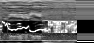

In [215]:
cv2_imshow(np.floor(x_trainnew[7009]*256))

In [0]:
!rm -rf meld_images

In [0]:
def save_images(xs, ys, trainorval = "train"):
    parent_folder = "meld_images"
    for i,(x,y) in enumerate(zip(xs,ys)):
        dest = Path(parent_folder + "/" + trainorval + "/" + str(y) + "/" + str(i) + ".png")
        dest.parent.mkdir(parents=True, exist_ok=True)
        saved = cv2.imwrite(str(dest), np.floor(x*256))

In [0]:
save_images(x_trainnew, y_trainnew, "train")

In [0]:
save_images(x_val, y_val, "val")

In [0]:
path = Path("meld_images/")

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, valid = 'val', bs=64);

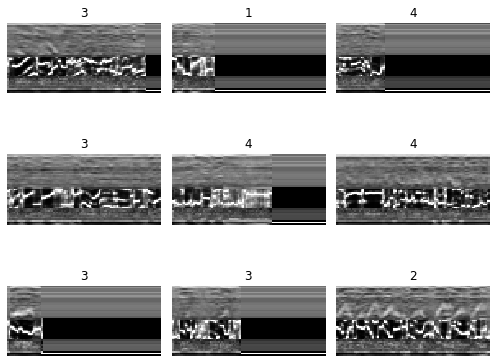

In [254]:
data.show_batch(rows=3, figsize=(7,6))

In [255]:
print(data.classes)
len(data.classes),data.c

['0', '1', '2', '3', '4']


(5, 5)

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, pretrained=False)

In [0]:
class_weights = torch.FloatTensor(np.array([1,2,5,3,5])).cuda()
learn.loss_func = nn.CrossEntropyLoss(weight = class_weights)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


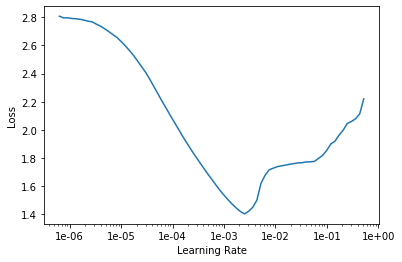

In [258]:
learn.lr_find()
learn.recorder.plot()

In [262]:
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,2.149272,1.751890,0.644578,00:09
1,1.356993,1.906062,0.478313,00:09
2,0.900400,1.842091,0.669880,00:09
3,0.629450,2.095556,0.689157,00:09
4,0.453099,2.065266,0.633735,00:09
5,0.331217,2.127602,0.562651,00:09
6,0.245285,2.206756,0.561446,00:09
7,0.183936,2.265404,0.524096,00:09
8,0.140129,2.312851,0.512048,00:09
9,0.109084,2.317119,0.504819,00:09


In [263]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

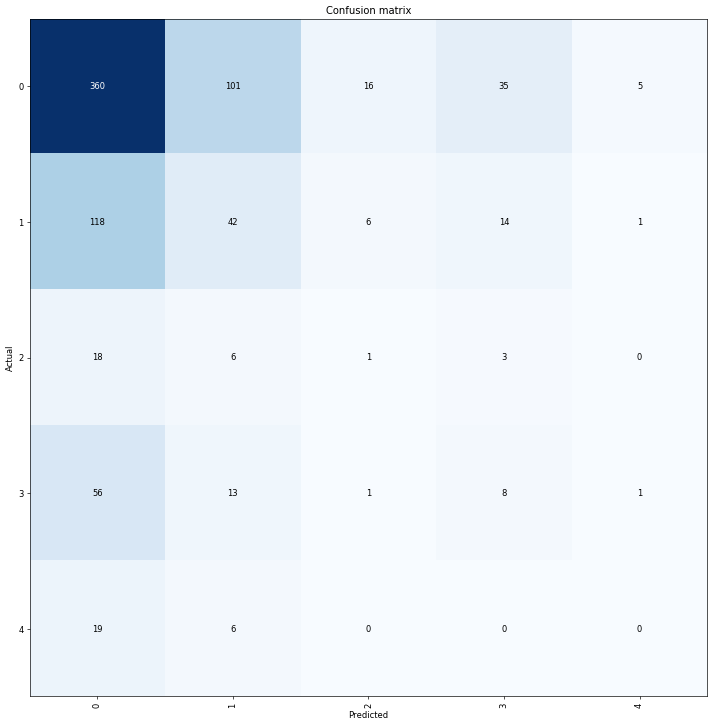

In [264]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)